In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from scipy.sparse import csr_matrix
import seaborn as sns
import numpy as np
import scipy
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Import labeled dataset

In [5]:
#Import the dataset
data_path = '/Users/romainberquet/Desktop/epfl/ml-fin/Projet/archive/all-data.csv'
df = pd.read_csv(data_path, 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])

In [6]:
df = df.rename(columns={'Text' : 'text' , 'Sentiment' : 'sentiment'})

In [7]:
df["text"]=df["text"].str.lower() #We convert our texts to lowercase.
df["text"]=df["text"].str.replace("[^\w\s]","") #We remove punctuation marks from our texts.

In [6]:
#Perform data exploration on the dataset
print(df.head())

  sentiment                                               text
0   neutral  according to gran , the company has no plans t...
1   neutral  technopolis plans to develop in stages an area...
2  negative  the international electronic industry company ...
3  positive  with the new production plant the company woul...
4  positive  according to the company 's updated strategy f...


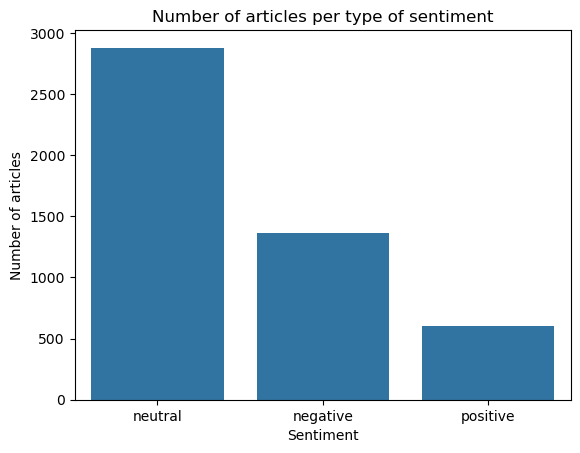

The proportion of each sentiment in the dataset is 
 sentiment
neutral     0.594098
positive    0.281263
negative    0.124639
Name: proportion, dtype: float64


In [7]:
ax = sns.barplot(x= df.sentiment.unique(), y=df.sentiment.value_counts())
ax.set(xlabel='Sentiment', ylabel='Number of articles' , title='Number of articles per type of sentiment')
plt.show()

sentiment_proportions = df['sentiment'].value_counts(normalize=True)
print(f"The proportion of each sentiment in the dataset is \n {sentiment_proportions}")

The dataset is relatively imbalanced with a high proportion of neutral comments

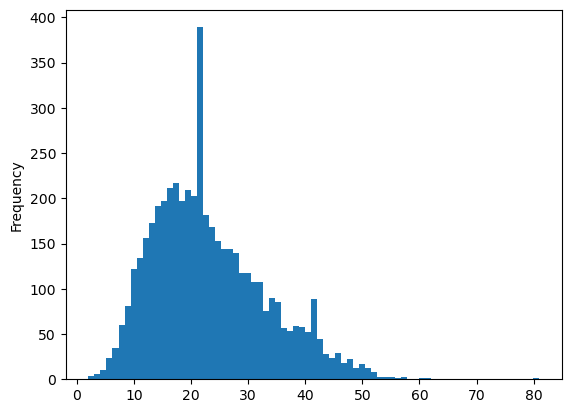

In [8]:
#Plot the distribution of the number of words per article
df['text'].apply(lambda x: len(x.split(" "))).mean()
df['text'].apply(lambda x: len(x.split(" "))).plot(kind='hist' , bins=  75)
plt.show()

We have no empty articles and the distribution of the length is relatively well balanced among articles.

In [9]:
#We map the sentiment to a numerical value positive : 1, neutral 0 and negative 2
df['sentiment'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': 2})

# Benchmark models

## Benchmark model : Bag of words

In [10]:
# Splitting the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

# Convert text data into a bag-of-words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)

In [11]:
def svm_classifier (X_train, y_train, X_test):
    # Train the model
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)

    # Predict the sentiment for the test data
    y_pred = svm.predict(X_test)

    return y_pred

In [12]:
def gradient_boosting_classifier (X_train, y_train, X_test):
    # Train a Gradient Boosting classifier
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = xgb_clf.predict(X_test)

    return y_pred

In [13]:
def naive_bayes_classifier (X_train, y_train, X_test):
    # Train a Naive Bayes classifier
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = nb_clf.predict(X_test)
    # Evaluate using accuracy, precision, recall, F1-score as before

    return y_pred

In [14]:
def mlp_classifier(X_train, y_train, X_test):

    if isinstance(X_train, csr_matrix):
        X_train_dense = X_train.toarray()
    else:
        X_train_dense = X_train

    if isinstance(X_test, csr_matrix):
        X_test_dense = X_test.toarray()
    else:
        X_test_dense = X_test

    mlp = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', solver='adam', 
                        max_iter=35, batch_size=128, verbose=True)

    mlp.fit(X_train_dense, y_train)

    # Predict
    y_pred = mlp.predict(X_test_dense)

    return y_pred
  

In [15]:
def logistic_regression_classifier(X_train, y_train, X_test):
    # Train a logistic regression classifier
    lr_clf = LogisticRegression(max_iter=1000)
    lr_clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = lr_clf.predict(X_test)

    return y_pred

In [18]:
#Classification using bag of words
y_pred_svm_bow = svm_classifier(X_train_bow, y_train_bow, X_test_bow)
y_pred_xgb_bow  = gradient_boosting_classifier(X_train_bow, y_train_bow, X_test_bow)
y_pred_nb_bow  = naive_bayes_classifier(X_train_bow, y_train_bow, X_test_bow)
y_pred_mlp_bow  = mlp_classifier(X_train_bow, y_train_bow, X_test_bow)

Iteration 1, loss = 0.82071272
Iteration 2, loss = 0.30960535
Iteration 3, loss = 0.07497312
Iteration 4, loss = 0.02506634
Iteration 5, loss = 0.01473156
Iteration 6, loss = 0.01136367
Iteration 7, loss = 0.00783599
Iteration 8, loss = 0.00544918
Iteration 9, loss = 0.00781694
Iteration 10, loss = 0.00627710
Iteration 11, loss = 0.00488251
Iteration 12, loss = 0.00432743
Iteration 13, loss = 0.00310089
Iteration 14, loss = 0.00323460
Iteration 15, loss = 0.00242829
Iteration 16, loss = 0.00319888
Iteration 17, loss = 0.00296451
Iteration 18, loss = 0.00308375
Iteration 19, loss = 0.00288120
Iteration 20, loss = 0.00211709
Iteration 21, loss = 0.00171901
Iteration 22, loss = 0.00166857
Iteration 23, loss = 0.00157745
Iteration 24, loss = 0.00174214
Iteration 25, loss = 0.00168557
Iteration 26, loss = 0.00146030
Iteration 27, loss = 0.00141525
Iteration 28, loss = 0.00159195
Iteration 29, loss = 0.00169484
Iteration 30, loss = 0.00110714
Iteration 31, loss = 0.00163321
Iteration 32, los

/Users/romainberquet/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
def update_performance(df, model_name, y_test, y_pred):

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract weighted average metrics
    weighted_avg = report['weighted avg']
    precision = weighted_avg['precision']
    recall = weighted_avg['recall']
    f1_score = weighted_avg['f1-score']

    # Create a new DataFrame for the row to be added
    new_row_df = pd.DataFrame({'Model': [model_name], 
                               'Precision': [precision], 
                               'Recall': [recall], 
                               'F1-Score': [f1_score]})

    # Concatenate the new row with the existing DataFrame
    df = pd.concat([df, new_row_df], ignore_index=True)
    
    return df

In [32]:
#Define a dataframe that will contain the performance of the different models
performance_df_bow = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score'])

In [33]:
def plot_performance(performance_df):    
    # Plotting
    n_models = len(performance_df_bow)
    ind = np.arange(n_models)  # the x locations for the groups
    width = 0.25  # the width of the bars
    sns.set_style("whitegrid")
    sns.set_palette("Set2")
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plotting each metric
    rects1 = ax.bar(ind - width, performance_df['Precision'], width, label='Precision')
    rects2 = ax.bar(ind, performance_df['Recall'], width, label='Recall')
    rects3 = ax.bar(ind + width, performance_df['F1-Score'], width, label='F1-Score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Performance by Model and Metric')
    ax.set_xticks(ind)
    ax.set_xticklabels(performance_df['Model'])
    ax.legend()

    # Attach a text label above each bar in *rects*, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Call the function to attach the labels
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    # Show the plot
    plt.show()

/var/folders/d9/q7rftjxx3pd2mksp5nhnv4b80000gn/T/ipykernel_6654/3712241522.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row_df], ignore_index=True)


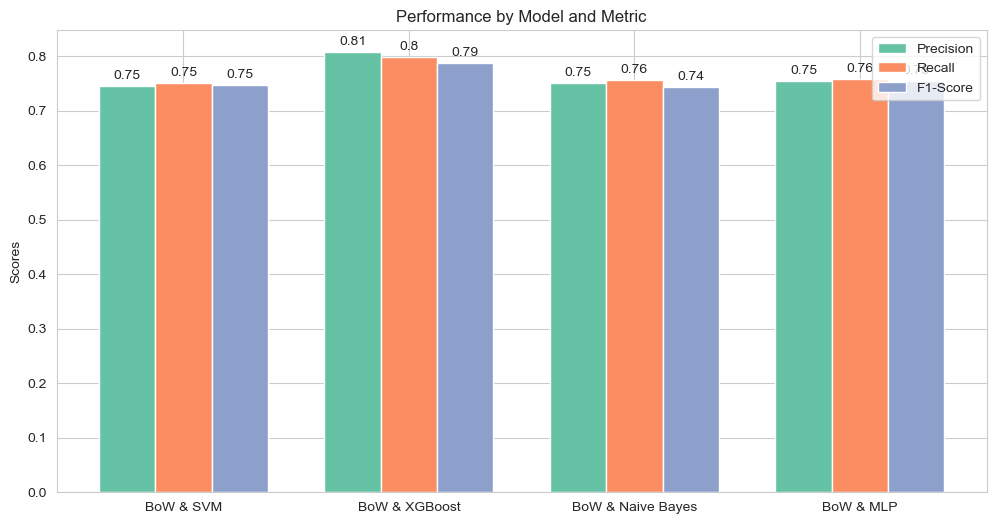

In [34]:
performance_df_bow = update_performance(performance_df_bow, 'BoW & SVM', y_test_bow, y_pred_svm_bow)
performance_df_bow = update_performance(performance_df_bow, 'BoW & XGBoost', y_test_bow, y_pred_xgb_bow)
performance_df_bow = update_performance(performance_df_bow, 'BoW & Naive Bayes', y_test_bow, y_pred_nb_bow)
performance_df_bow = update_performance(performance_df_bow, 'BoW & MLP', y_test_bow, y_pred_mlp_bow)

plot_performance(performance_df_bow)

### Benchmark model : TF-IDF (Term Frequency-Inverse Frequency)

In [36]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf)

# Only transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf)

In [38]:
#Classification using bag of words
y_pred_svm_tfidf = svm_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)
y_pred_xgb_tfidf  = gradient_boosting_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)
y_pred_nb_tfidf  = naive_bayes_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)
y_pred_mlp_tfidf = mlp_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)

Iteration 1, loss = 0.91437632
Iteration 2, loss = 0.56715326
Iteration 3, loss = 0.20184185
Iteration 4, loss = 0.05555525
Iteration 5, loss = 0.02452708
Iteration 6, loss = 0.01422428
Iteration 7, loss = 0.01005533
Iteration 8, loss = 0.01134393
Iteration 9, loss = 0.01010488
Iteration 10, loss = 0.00714688
Iteration 11, loss = 0.00644575
Iteration 12, loss = 0.00683589
Iteration 13, loss = 0.00544572
Iteration 14, loss = 0.00422736
Iteration 15, loss = 0.00466939
Iteration 16, loss = 0.00455215
Iteration 17, loss = 0.00523411
Iteration 18, loss = 0.00495356
Iteration 19, loss = 0.00270417
Iteration 20, loss = 0.00253652
Iteration 21, loss = 0.00345097
Iteration 22, loss = 0.00207818
Iteration 23, loss = 0.00236932
Iteration 24, loss = 0.00330568
Iteration 25, loss = 0.00195328
Iteration 26, loss = 0.00202636
Iteration 27, loss = 0.00252686
Iteration 28, loss = 0.00264998
Iteration 29, loss = 0.00288452
Iteration 30, loss = 0.00297118
Iteration 31, loss = 0.00207684
Iteration 32, los

/Users/romainberquet/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(


/var/folders/d9/q7rftjxx3pd2mksp5nhnv4b80000gn/T/ipykernel_6654/3712241522.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row_df], ignore_index=True)


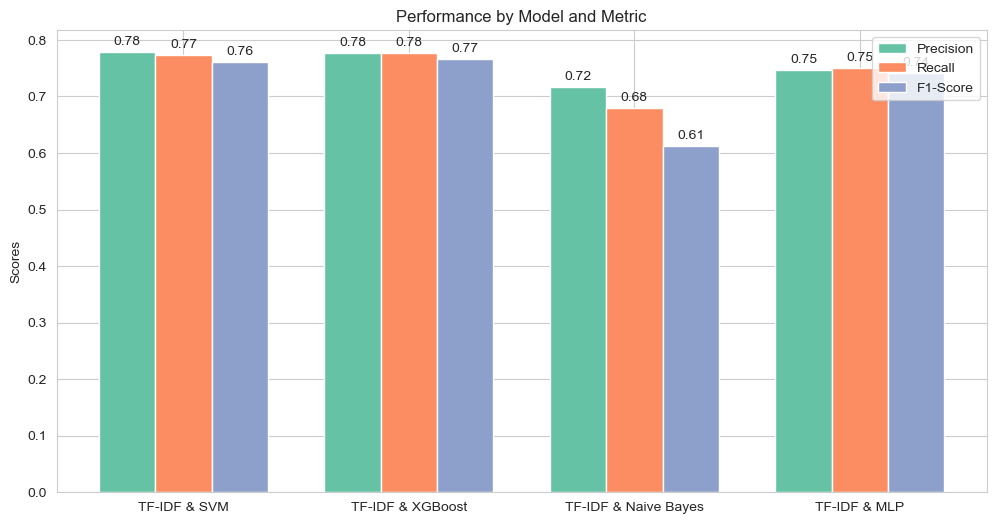

In [48]:
performance_df_tfidf = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score'])

performance_df_tfidf = update_performance(performance_df_tfidf, 'TF-IDF & SVM', y_test_tfidf, y_pred_svm_tfidf)
performance_df_tfidf = update_performance(performance_df_tfidf, 'TF-IDF & XGBoost', y_test_tfidf, y_pred_xgb_tfidf)
performance_df_tfidf = update_performance(performance_df_tfidf, 'TF-IDF & Naive Bayes', y_test_tfidf, y_pred_nb_tfidf)
performance_df_tfidf = update_performance(performance_df_tfidf, 'TF-IDF & MLP', y_test_tfidf, y_pred_mlp_tfidf)

plot_performance(performance_df_tfidf)

### Benchmark model : GloVe

In [40]:
def load_glove_model(glove_file_path):
    print("Loading Glove Model")
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        glove_model = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
        print(f"{len(glove_model)} words loaded!")
        return glove_model

glove_path = '/Users/romainberquet/Desktop/epfl/ml-fin/Projet/glove.6B/glove.6B.300d.txt'  
glove_model = load_glove_model(glove_path)

X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

Loading Glove Model
400000 words loaded!


In [41]:
def document_vector(glove_model, doc):
    words = doc.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)  # 300 is the GloVe vector size

X_train_vectors_glove = np.array([document_vector(glove_model, text) for text in X_train_glove])
X_test_vectors_glove = np.array([document_vector(glove_model, text) for text in X_test_glove])

In [53]:
#Classification using bag of words
y_pred_svm_Glove = svm_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)
y_pred_xgb_Glove  = gradient_boosting_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)
y_pred_mlp_Glove = mlp_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)

#Add a logistic regression classifier
y_pred_lr_Glove = logistic_regression_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)

Iteration 1, loss = 0.82990414
Iteration 2, loss = 0.68604612
Iteration 3, loss = 0.60980590
Iteration 4, loss = 0.55769993
Iteration 5, loss = 0.53606102
Iteration 6, loss = 0.48976238
Iteration 7, loss = 0.45343337
Iteration 8, loss = 0.41861351
Iteration 9, loss = 0.37794645
Iteration 10, loss = 0.34578983
Iteration 11, loss = 0.31326876
Iteration 12, loss = 0.28033854
Iteration 13, loss = 0.24647459
Iteration 14, loss = 0.21034364
Iteration 15, loss = 0.20396364
Iteration 16, loss = 0.14757549
Iteration 17, loss = 0.12841403
Iteration 18, loss = 0.12335240
Iteration 19, loss = 0.10382456
Iteration 20, loss = 0.09558718
Iteration 21, loss = 0.06847866
Iteration 22, loss = 0.05973947
Iteration 23, loss = 0.05462049
Iteration 24, loss = 0.04446103
Iteration 25, loss = 0.03945768
Iteration 26, loss = 0.03624944
Iteration 27, loss = 0.03918173
Iteration 28, loss = 0.03343771
Iteration 29, loss = 0.02760986
Iteration 30, loss = 0.03714687
Iteration 31, loss = 0.02617523
Iteration 32, los

/Users/romainberquet/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(


/var/folders/d9/q7rftjxx3pd2mksp5nhnv4b80000gn/T/ipykernel_6654/3712241522.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row_df], ignore_index=True)


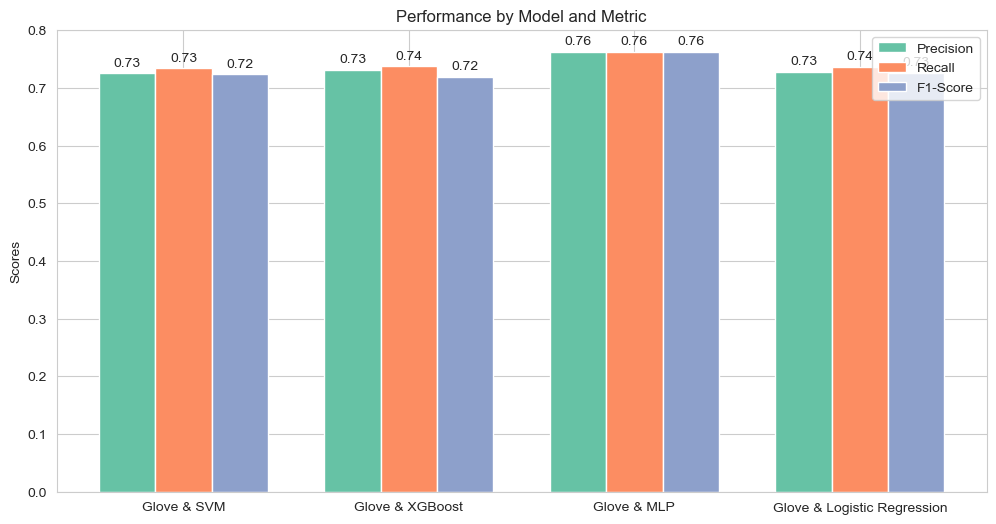

In [55]:
performance_df_glove = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-Score'])

performance_df_glove = update_performance(performance_df_glove, 'Glove & SVM', y_test_glove, y_pred_svm_Glove)
performance_df_glove = update_performance(performance_df_glove, 'Glove & XGBoost', y_test_glove, y_pred_xgb_Glove)
performance_df_glove = update_performance(performance_df_glove, 'Glove & MLP', y_test_glove, y_pred_mlp_Glove)
performance_df_glove = update_performance(performance_df_glove, 'Glove & Logistic Regression', y_test_glove, y_pred_lr_Glove)


plot_performance(performance_df_glove)

### Financial BERT

In [55]:
tokenizer_finbert = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [56]:
X_test_finbert = df['text'].to_list()
y_test_finbert = df['sentiment'].to_list()

In [57]:
def classify_model(X_train , tokenizer , model) :
    preds = []
    preds_proba = []
    tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
    for x in X_train:
        with torch.no_grad():
            input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
            logits = model(**input_sequence).logits
            scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),
                scipy.special.softmax(logits.numpy().squeeze()),
            )
        }
        sentiment = max(scores, key=scores.get)
        probability = max(scores.values())
        preds.append(sentiment)
        preds_proba.append(probability)

    return preds, preds_proba

In [58]:
#Map the predictions to numerical values
y_pred_finbert, y_pred_proba_finbert = classify_model(X_test_finbert, tokenizer_finbert, model_finbert)

In [59]:
#Asses the performance of the model
finbert_performance = pd.DataFrame(classification_report(y_pred_finbert, y_test_finbert, output_dict=True))
finbert_performance

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.970199,0.857589,0.920763,0.889393,0.916184,0.894769
recall,0.801642,0.962198,0.810200,0.889393,0.858013,0.889393
f1-score,0.877903,0.906887,0.861951,0.889393,0.882247,0.888151
support,731.000000,2566.000000,1549.000000,0.889393,4846.000000,4846.000000


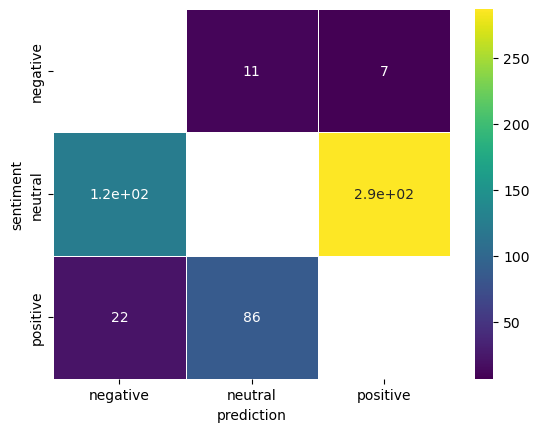

In [94]:
#FinBert is the most accurate model, we will look at the predictions it made and the probability it assigned to each prediction
finbert_df = pd.DataFrame({'text': X_test_finbert, 'sentiment': y_test_finbert, 'prediction': y_pred_finbert, 'probability': y_pred_proba_finbert})

#We look at the articles that were misclassified
missclassified = finbert_df[finbert_df['sentiment'] != finbert_df['prediction']]

#Count the number of pairs of sentiment and prediction
missclassified = missclassified.groupby(['sentiment', 'prediction']).count().reset_index().drop(columns=['probability'])

#plot a heat map of the number of misclassified articles
missclassified = missclassified.pivot(index='sentiment', columns='prediction', values='text')
sns.heatmap(missclassified, annot=True, cmap="viridis", linewidths=.5)
plt.show()

/Users/romainberquet/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


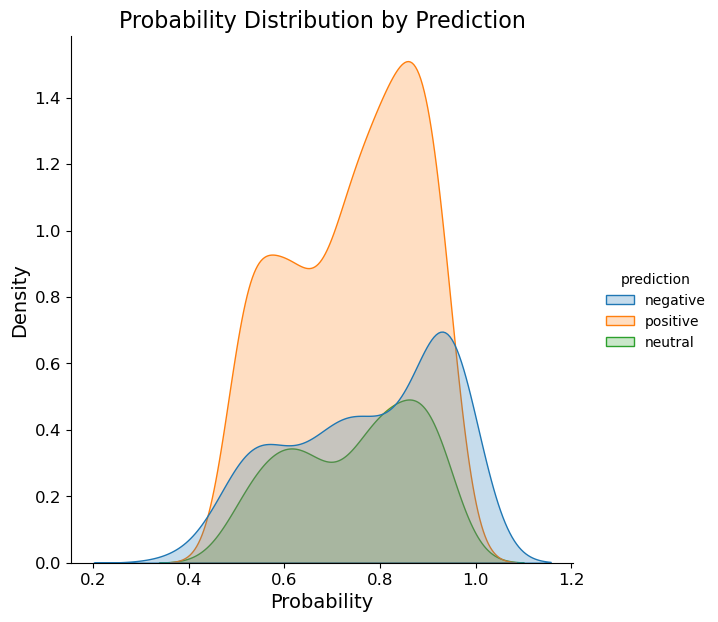

In [92]:
#Plot the distribution of the probability of the prediction
missclassified = finbert_df[finbert_df['sentiment'] != finbert_df['prediction']]

# Improved version
sns.displot(missclassified, x="probability", hue="prediction", kind="kde", fill=True, height=6)
plt.title("Probability Distribution by Prediction", fontsize=16)  
plt.xlabel("Probability", fontsize=14)
plt.ylabel("Density", fontsize=14) 
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12) 
plt.show()

### RoBERTa

In [61]:
tokenizer_roberta = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model_roberta = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [62]:
X_test_roberta = df['text'].to_list()
y_test_roberta = df['sentiment'].to_list()

In [63]:
#Map the predictions to numerical values
y_pred_roberta, y_pred_proba_roberta = classify_model(X_test_roberta , tokenizer_roberta , model_roberta)

In [64]:
#Asses the performance of the model
roberta_performance = pd.DataFrame(classification_report(y_pred_roberta, y_test_roberta, output_dict=True))
roberta_performance

,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.773179,0.894755,0.809978,0.855757,0.825971,0.857253
recall,0.871269,0.877683,0.802909,0.855757,0.850620,0.855757
f1-score,0.819298,0.886137,0.806428,0.855757,0.837288,0.856128
support,536.000000,2935.000000,1375.000000,0.855757,4846.000000,4846.000000
